In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math
import dabl

In [2]:
# Load the dataset
file_path = "dags/data/RTA_Dataset.csv"
df = pd.read_csv(file_path) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [3]:
df.head()

# All the fields except Number_of_vehicles_involved and Number_of_casualties are objects => categorical attributes

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [4]:
# Describe the data, identify null column values

display(df.isnull().sum())
display(df.describe())

# Total records = 12316
# We can observe that nearly 1/3 of entries have null value for Defect_of_vehicle, Service_year_of_vehicle

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

,Number_of_vehicles_involved,Number_of_casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000


In [5]:
# Remove unnecessary columns

# Decision: Remove Defect_of_vehicle, Service_year_of_vehicle, Work_of_casuality, Fitness_of_casuality
# Because these attributes are unrelated in our prediction of traffic accidents based on traffic conditions and high percentage of null values
df_cleaned = df.drop(columns=['Defect_of_vehicle', 'Service_year_of_vehicle', 'Work_of_casuality', 'Fitness_of_casuality'])

display(df_cleaned.isnull().sum())

Time                             0
Day_of_week                      0
Age_band_of_driver               0
Sex_of_driver                    0
Educational_level              741
Vehicle_driver_relation        579
Driving_experience             829
Type_of_vehicle                950
Owner_of_vehicle               482
Area_accident_occured          239
Lanes_or_Medians               385
Road_allignment                142
Types_of_Junction              887
Road_surface_type              172
Road_surface_conditions          0
Light_conditions                 0
Weather_conditions               0
Type_of_collision              155
Number_of_vehicles_involved      0
Number_of_casualties             0
Vehicle_movement               308
Casualty_class                   0
Sex_of_casualty                  0
Age_band_of_casualty             0
Casualty_severity                0
Pedestrian_movement              0
Cause_of_accident                0
Accident_severity                0
dtype: int64

In [6]:
# Standardize column values (lowercase, strip spaces, replace underscores)
df_cleaned.columns = df_cleaned.columns.str.lower().str.replace(" ", "_")

# Rename the spelling error
df_cleaned.rename(columns={"road_allignment": "road_alignment"}, inplace=True)

In [7]:
df_cleaned.columns

Index(['time', 'day_of_week', 'age_band_of_driver', 'sex_of_driver',
       'educational_level', 'vehicle_driver_relation', 'driving_experience',
       'type_of_vehicle', 'owner_of_vehicle', 'area_accident_occured',
       'lanes_or_medians', 'road_alignment', 'types_of_junction',
       'road_surface_type', 'road_surface_conditions', 'light_conditions',
       'weather_conditions', 'type_of_collision',
       'number_of_vehicles_involved', 'number_of_casualties',
       'vehicle_movement', 'casualty_class', 'sex_of_casualty',
       'age_band_of_casualty', 'casualty_severity', 'pedestrian_movement',
       'cause_of_accident', 'accident_severity'],
      dtype='object')

In [8]:
# No removal of duplicate rows as accident records are not unique

time
15:30:00    120
17:10:00    110
18:30:00    103
11:30:00     99
17:00:00     98
           ... 
0:52:00       1
4:49:00       1
14:31:00      1
19:18:00      1
2:47:00       1
Name: count, Length: 1074, dtype: int64


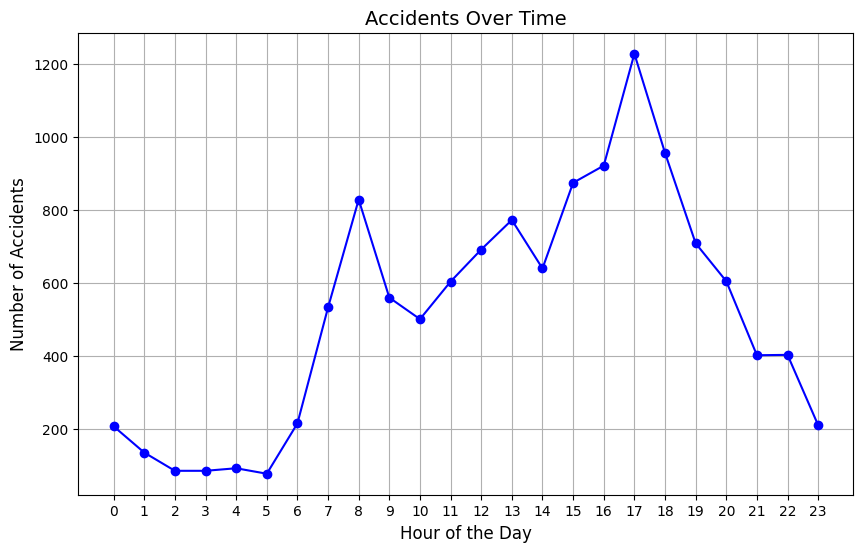

In [9]:
print(df_cleaned["time"].value_counts())

df_cleaned["time"] = pd.to_datetime(df_cleaned["time"], format="%H:%M:%S")
df_cleaned["hour"] = df_cleaned["time"].dt.hour # group by the hour
time_series = df_cleaned.groupby("hour").size()  # Count accidents per hour

plt.figure(figsize=(10, 6))
plt.plot(time_series.index, time_series.values, marker="o", linestyle="-", color="b")

# Formatting
plt.title("Accidents Over Time", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)
plt.xticks(range(0, 24))  # Show every hour
plt.grid(True)

plt.show()

In [10]:
print(df_cleaned["day_of_week"].value_counts())

day_of_week
Friday       2041
Thursday     1851
Wednesday    1840
Tuesday      1770
Monday       1681
Saturday     1666
Sunday       1467
Name: count, dtype: int64


age_band_of_driver
18-30       4271
31-50       4087
Over 51     1585
Unknown     1548
Under 18     825
Name: count, dtype: int64


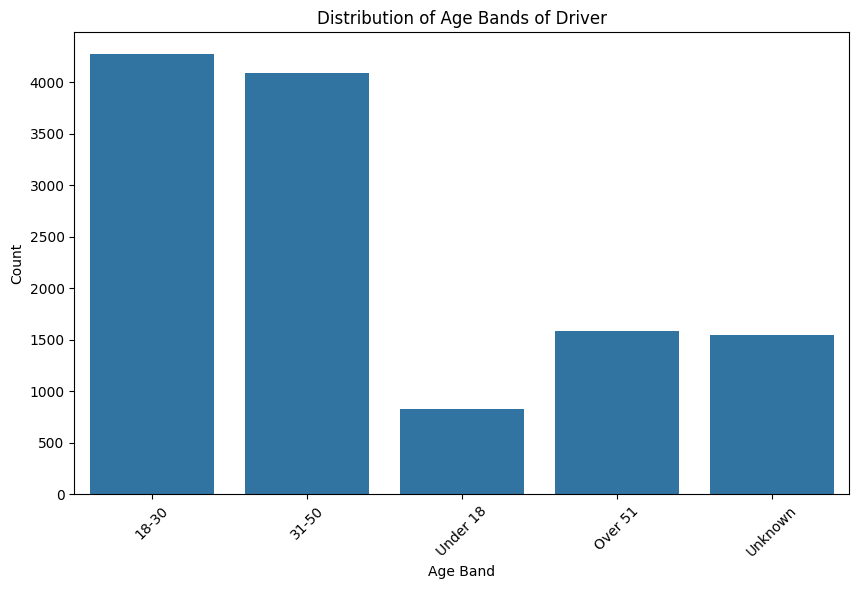

In [11]:
# Distributional analysis of data for driver characteristics
print(df_cleaned["age_band_of_driver"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='age_band_of_driver', data=df_cleaned)
plt.title('Distribution of Age Bands of Driver')
plt.xlabel('Age Band')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()


sex_of_driver
Male       11437
Female       701
Unknown      178
Name: count, dtype: int64


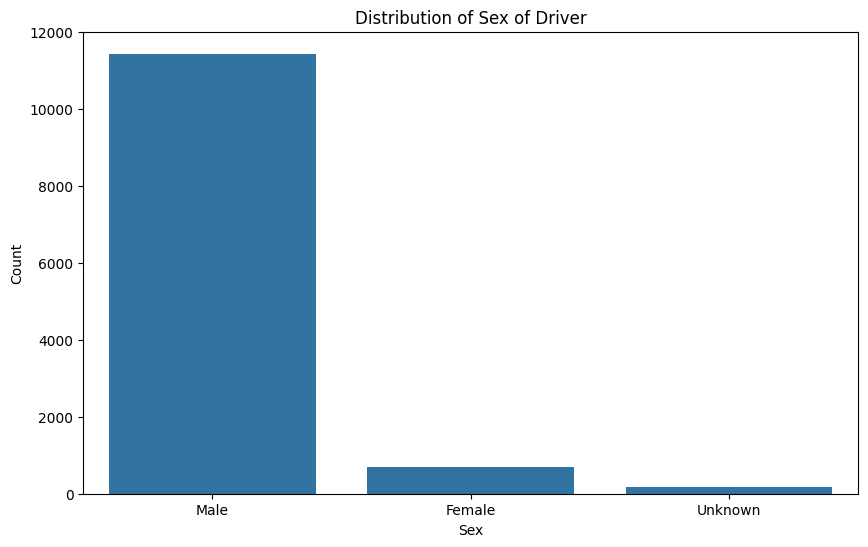

In [12]:
print(df_cleaned["sex_of_driver"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='sex_of_driver', data=df_cleaned)
plt.title('Distribution of Sex of Driver')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

educational_level
Junior high school    7619
Elementary school     2163
High school           1110
Above high school      362
Writing & reading      176
Unknown                100
Illiterate              45
Name: count, dtype: int64


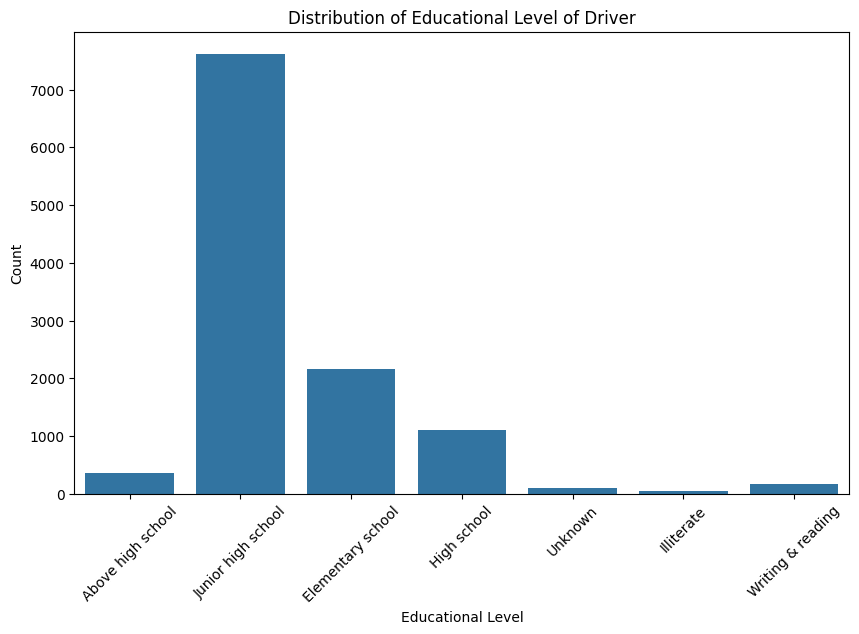

In [13]:
print(df_cleaned["educational_level"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='educational_level', data=df_cleaned)
plt.title('Distribution of Educational Level of Driver')
plt.xlabel('Educational Level')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

vehicle_driver_relation
Employee    9627
Owner       1973
Other        123
Unknown       14
Name: count, dtype: int64


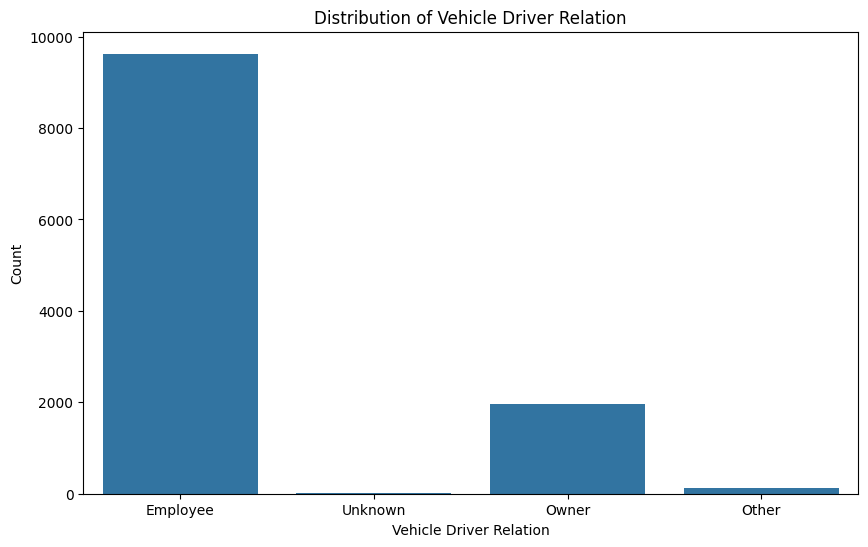

In [14]:
print(df_cleaned["vehicle_driver_relation"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='vehicle_driver_relation', data=df_cleaned)
plt.title('Distribution of Vehicle Driver Relation')
plt.xlabel('Vehicle Driver Relation')
plt.ylabel('Count')
plt.show()


driving_experience
5-10yr        3363
2-5yr         2613
Above 10yr    2262
1-2yr         1756
Below 1yr     1342
No Licence     118
unknown         33
Name: count, dtype: int64


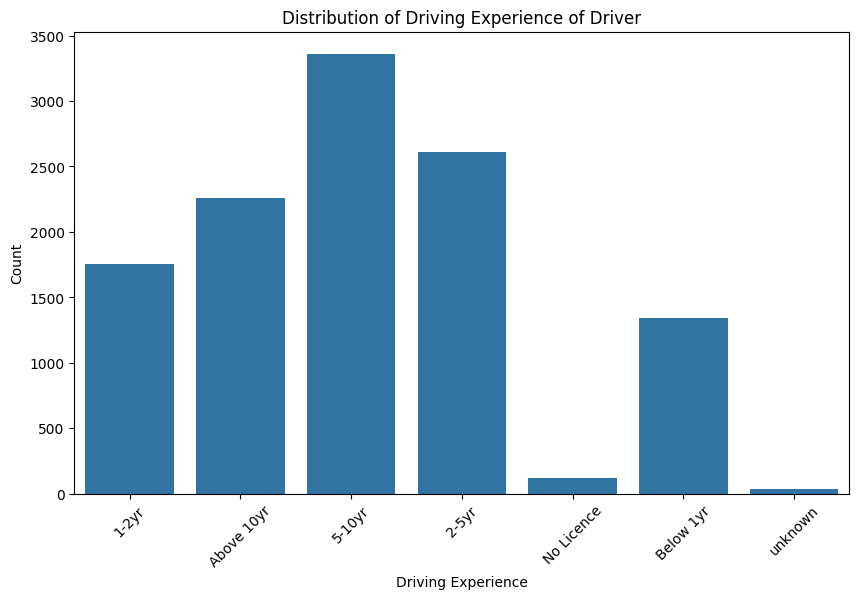

In [15]:
print(df_cleaned["driving_experience"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='driving_experience', data=df_cleaned)
plt.title('Distribution of Driving Experience of Driver')
plt.xlabel('Driving Experience')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

type_of_vehicle
Automobile              3205
Lorry (41?100Q)         2186
Other                   1208
Pick up upto 10Q         811
Public (12 seats)        711
Stationwagen             687
Lorry (11?40Q)           541
Public (13?45 seats)     532
Public (> 45 seats)      404
Long lorry               383
Taxi                     265
Motorcycle               177
Special vehicle           84
Ridden horse              76
Turbo                     46
Bajaj                     29
Bicycle                   21
Name: count, dtype: int64


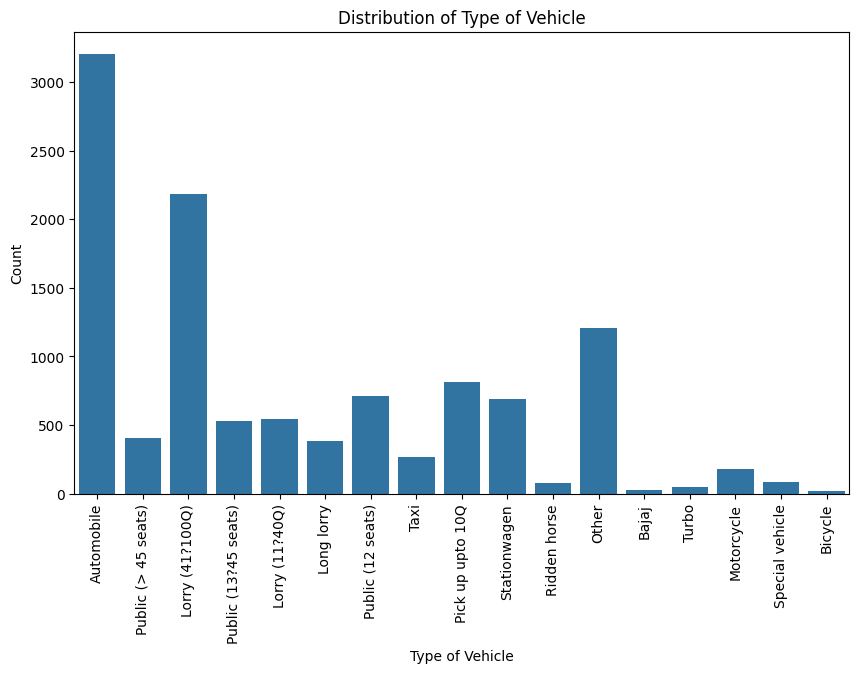

In [16]:
print(df_cleaned["type_of_vehicle"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='type_of_vehicle', data=df_cleaned)
plt.title('Distribution of Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=10)
plt.show()

owner_of_vehicle
Owner           10459
Governmental     1041
Organization      312
Other              22
Name: count, dtype: int64


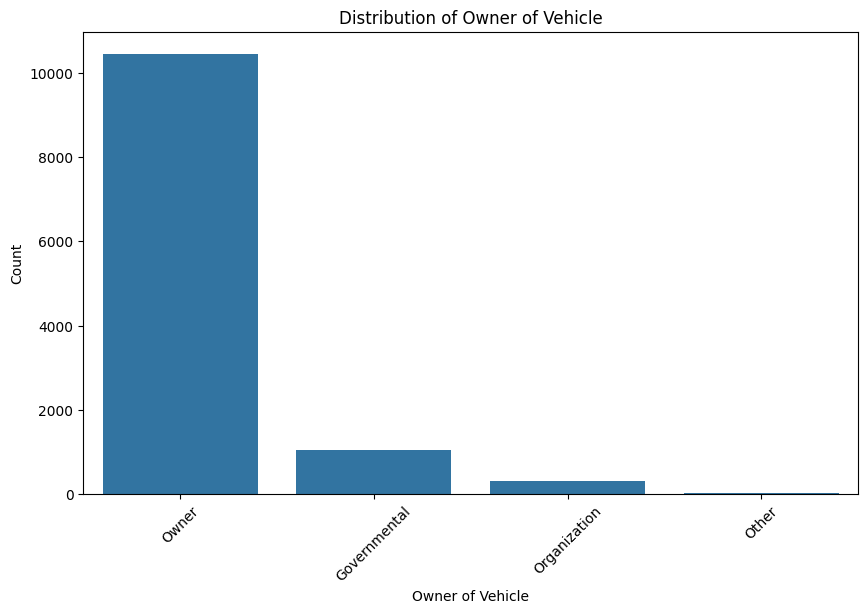

In [17]:
print(df_cleaned["owner_of_vehicle"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='owner_of_vehicle', data=df_cleaned)
plt.title('Distribution of Owner of Vehicle')
plt.xlabel('Owner of Vehicle')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [18]:
# Distributional analysis of data for traffic/road conditions

# print(df_cleaned["area_accident_occured"].value_counts())

# Mapping the area accident occurred to a more readable format
area_to_highway = {
    "Other": "road",
    "Office areas": "service",
    "Residential areas": "residential",
    "Church areas": "service",
    "Industrial areas": "service",
    "School areas": "living_street",
    "Recreational areas": "living_street",
    "Outside rural areas": "unclassified",
    "Hospital areas": "service",
    "Market areas": "living_street",
    "Rural village areas": "tertiary",
    "Unknown": "road",
    "Rural village areasOffice areas": "road",  # Inconsistent value
    # Possible trimmed version to cover any leading/trailing whitespace
    "  Recreational areas": "living_street",
    "  Market areas": "living_street"
}
df_cleaned["area_accident_occured"] = df_cleaned["area_accident_occured"].map(area_to_highway)
print(df_cleaned["area_accident_occured"].value_counts())

area_accident_occured
road             3861
service          3451
residential      2060
living_street     806
tertiary           44
Name: count, dtype: int64


In [19]:
print(df_cleaned["road_alignment"].value_counts())

road_alignment
Tangent road with flat terrain                   10459
Tangent road with mild grade and flat terrain      501
Steep grade downward with mountainous terrain      429
Tangent road with mountainous terrain and          396
Gentle horizontal curve                            163
Escarpments                                        113
Sharp reverse curve                                 57
Tangent road with rolling terrain                   37
Steep grade upward with mountainous terrain         19
Name: count, dtype: int64


In [20]:
# print(df_cleaned["types_of_junction"].value_counts())

# Mapping the types_of_junction to a more readable format
types_of_junction_to_types_of_junction = {
  "Y Shape":"y_shape",
  "No junction":"no_junction",
  "Crossing":  "crossing",
  "Other":  "other",
  "Unknown":  "unknown",
  "O Shape":"o_shape",
  "T Shape":"t_shape",
  "X Shape":"x_shape",
}
df_cleaned["types_of_junction"] = df_cleaned["types_of_junction"].map(types_of_junction_to_types_of_junction)
print(df_cleaned["types_of_junction"].value_counts())

types_of_junction
y_shape        4543
no_junction    3837
crossing       2177
other           445
unknown         191
o_shape         164
t_shape          60
x_shape          12
Name: count, dtype: int64


In [21]:
print(df_cleaned["road_surface_type"].value_counts())

road_surface_type
Asphalt roads                       11296
Earth roads                           358
Gravel roads                          242
Other                                 167
Asphalt roads with some distress       81
Name: count, dtype: int64


In [22]:
print(df_cleaned["road_surface_conditions"].value_counts())

road_surface_conditions
Dry                     9340
Wet or damp             2904
Snow                      70
Flood over 3cm. deep       2
Name: count, dtype: int64


In [23]:
print(df_cleaned["light_conditions"].value_counts())

light_conditions
Daylight                   8798
Darkness - lights lit      3286
Darkness - no lighting      192
Darkness - lights unlit      40
Name: count, dtype: int64


In [24]:
# Distributional analysis of data for accident details
print(df_cleaned["type_of_collision"].value_counts())

type_of_collision
Vehicle with vehicle collision             8774
Collision with roadside objects            1786
Collision with pedestrians                  896
Rollover                                    397
Collision with animals                      171
Collision with roadside-parked vehicles      54
Fall from vehicles                           34
Other                                        26
Unknown                                      14
With Train                                    9
Name: count, dtype: int64


number_of_vehicles_involved
2    8340
1    1996
3    1568
4     363
6      42
7       7
Name: count, dtype: int64


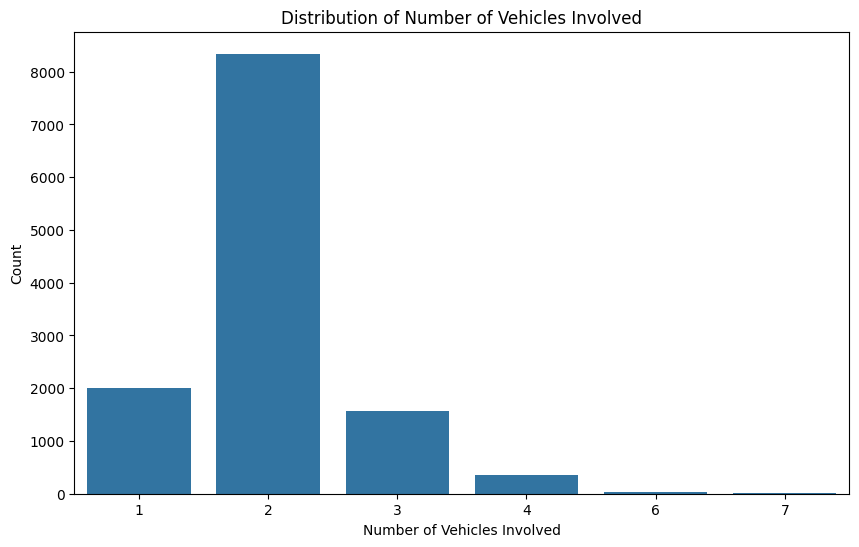

In [25]:
print(df_cleaned["number_of_vehicles_involved"].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_vehicles_involved', data=df_cleaned)
plt.title('Distribution of Number of Vehicles Involved')
plt.xlabel('Number of Vehicles Involved')
plt.ylabel('Count')
plt.show()

number_of_vehicles_involved
2    8340
1    1996
3    1568
4     363
6      42
7       7
Name: count, dtype: int64


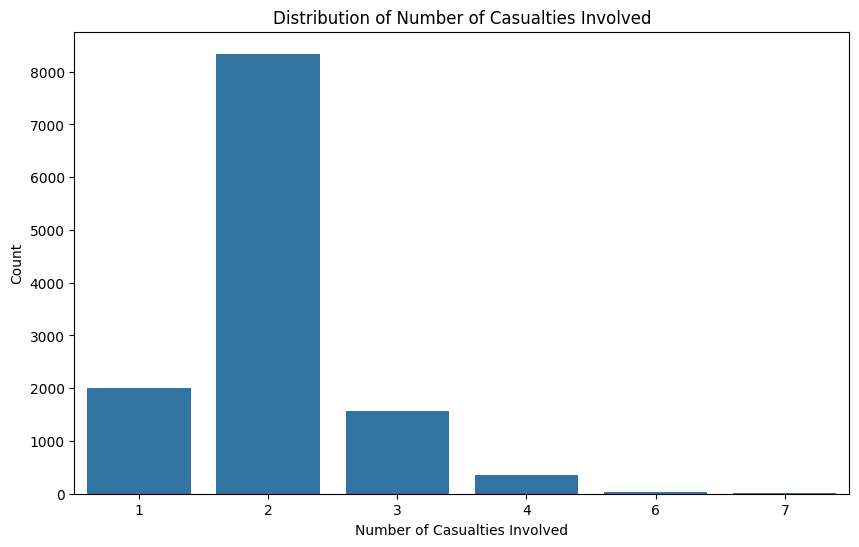

In [26]:
print(df_cleaned["number_of_vehicles_involved"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_vehicles_involved', data=df_cleaned)
plt.title('Distribution of Number of Casualties Involved')
plt.xlabel('Number of Casualties Involved')
plt.ylabel('Count')
plt.show()

number_of_vehicles_involved
2    8340
1    1996
3    1568
4     363
6      42
7       7
Name: count, dtype: int64


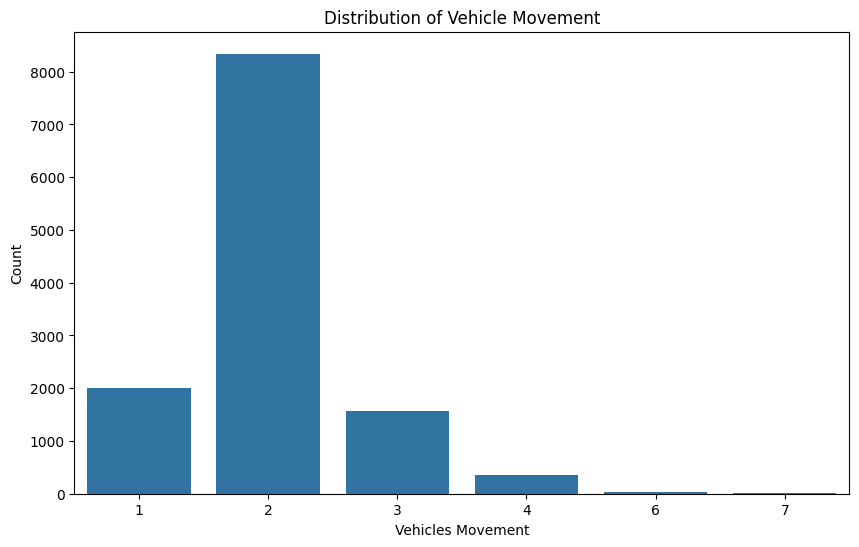

In [27]:
print(df_cleaned["number_of_vehicles_involved"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_vehicles_involved', data=df_cleaned)
plt.title('Distribution of Vehicle Movement')
plt.xlabel('Vehicles Movement')
plt.ylabel('Count')
plt.show()


casualty_class
Driver or rider    4944
na                 4443
Pedestrian         1649
Passenger          1280
Name: count, dtype: int64


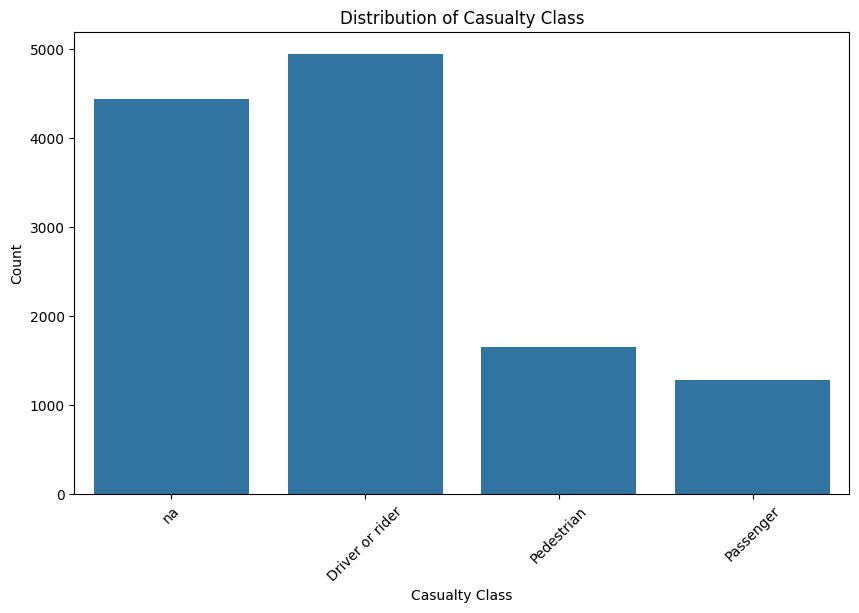

In [28]:
print(df_cleaned["casualty_class"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='casualty_class', data=df_cleaned)
plt.title('Distribution of Casualty Class')
plt.xlabel('Casualty Class')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [29]:
print(df_cleaned["sex_of_casualty"].value_counts())

sex_of_casualty
Male      5253
na        4443
Female    2620
Name: count, dtype: int64


In [30]:
# There are many NA values in casualty_class and sex_of_casualty. 
# Since these are not directly related to the goal of our prediction, we can drop these columns 
df_cleaned.drop(columns=["casualty_class", "sex_of_casualty"], inplace=True)

casualty_severity
3     7076
na    4443
2      771
1       26
Name: count, dtype: int64


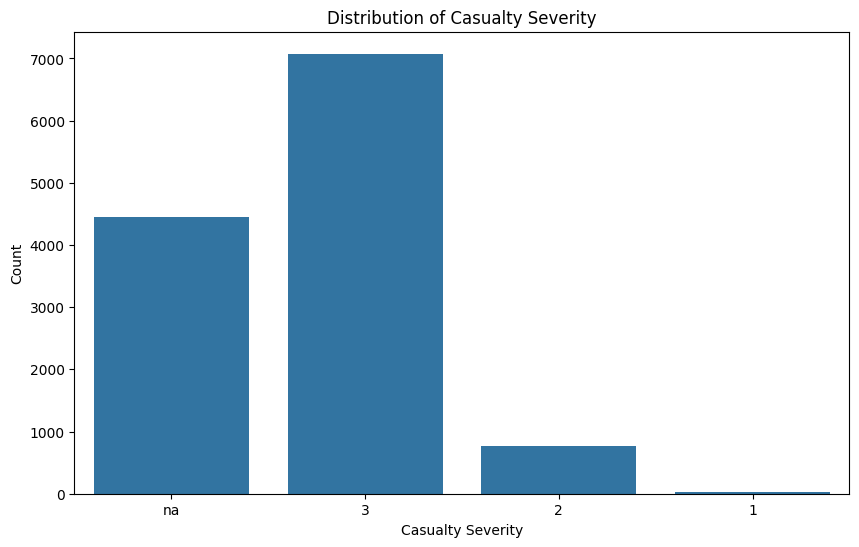

In [31]:
print(df_cleaned["casualty_severity"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='casualty_severity', data=df_cleaned)
plt.title('Distribution of Casualty Severity')
plt.xlabel('Casualty Severity')
plt.ylabel('Count')
plt.show()

In [32]:
print(df_cleaned["pedestrian_movement"].value_counts())

pedestrian_movement
Not a Pedestrian                                                                                                                         11390
Crossing from nearside - masked by parked or statioNot a Pedestrianry vehicle                                                              337
Unknown or other                                                                                                                           293
Crossing from driver's nearside                                                                                                            140
Crossing from offside - masked by  parked or statioNot a Pedestrianry vehicle                                                               72
In carriageway, statioNot a Pedestrianry - not crossing  (standing or playing)                                                              46
Walking along in carriageway, back to traffic                                                                             

cause_of_accident
No distancing                           2263
Changing lane to the right              1808
Changing lane to the left               1473
Driving carelessly                      1402
No priority to vehicle                  1207
Moving Backward                         1137
No priority to pedestrian                721
Other                                    456
Overtaking                               430
Driving under the influence of drugs     340
Driving to the left                      284
Getting off the vehicle improperly       197
Driving at high speed                    174
Overturning                              149
Turnover                                  78
Overspeed                                 61
Overloading                               59
Drunk driving                             27
Improper parking                          25
Unknown                                   25
Name: count, dtype: int64


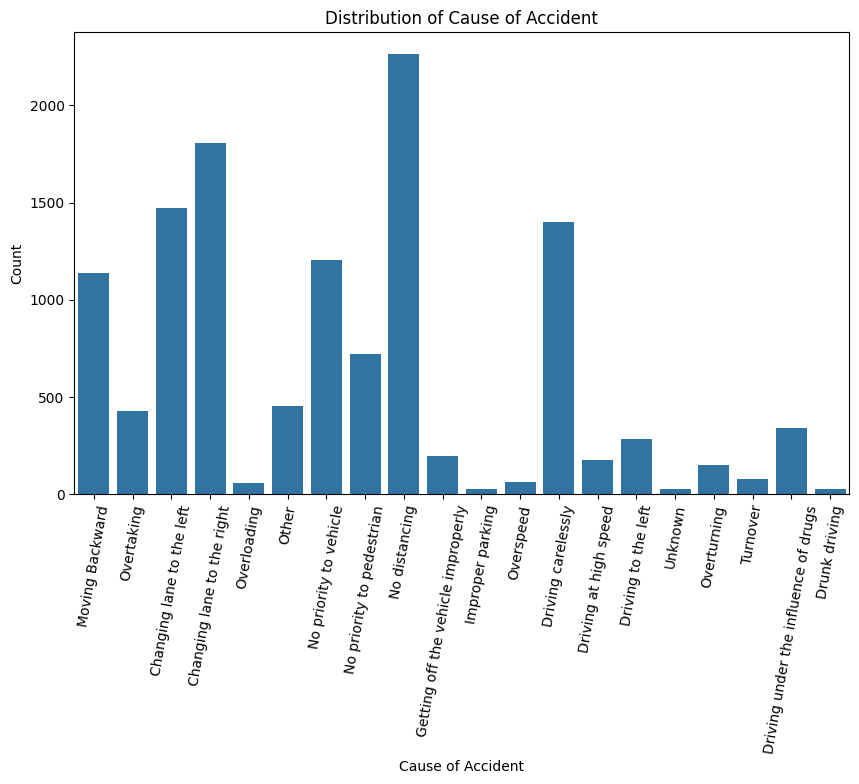

In [33]:
print(df_cleaned["cause_of_accident"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='cause_of_accident', data=df_cleaned)
plt.title('Distribution of Cause of Accident')
plt.xlabel('Cause of Accident')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=80)
plt.show()

accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64


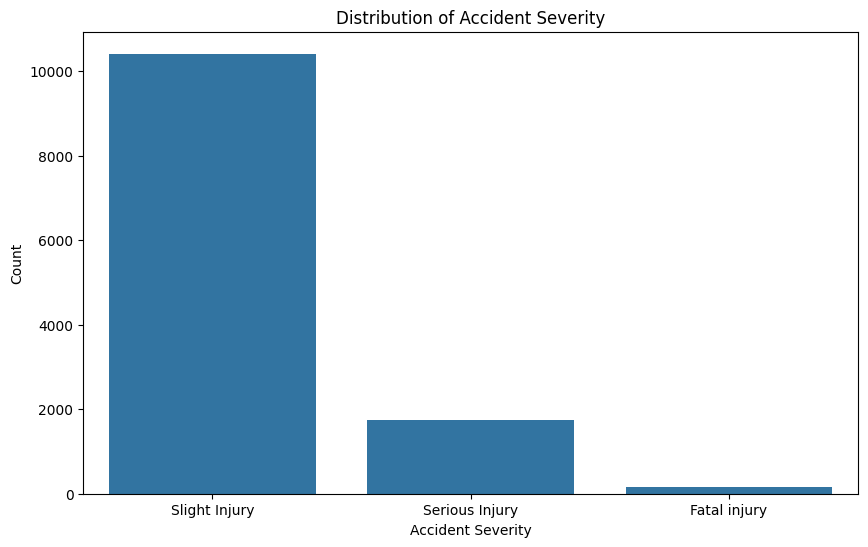

In [34]:
print(df_cleaned["accident_severity"].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='accident_severity', data=df_cleaned)
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()


In [35]:
# Fill missing categorical values with mode
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

C:\Users\jerly\AppData\Local\Temp\ipykernel_32604\1119502391.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)


C:\Users\jerly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dabl\preprocessing.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
C:\Users\jerly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dabl\preprocessing.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
C:\Users\jerly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dabl\preprocessing.py:177: UserWarning: Could not infer format, so each element will be parsed indivi

Target looks like classification


C:\Users\jerly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dabl\plot\utils.py:615: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in data.groupby(target)[column]:


Linear Discriminant Analysis training set score: 0.333
Showing only top 10 of 27 categorical features


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='accident_severity'>,
 [array([[<Axes: ylabel='number_of_casualties'>, <Axes: >],
         [<Axes: xlabel='number_of_casualties', ylabel='hour'>,
          <Axes: xlabel='hour'>]], dtype=object),
  <Figure size 800x400 with 2 Axes>,
  <Figure size 400x400 with 1 Axes>],
 array([[<Axes: title={'center': 'number_of_vehicles_involved'}>,
         <Axes: title={'center': 'age_band_of_driver'}>,
         <Axes: title={'center': 'types_of_junction'}>,
         <Axes: title={'center': 'weather_conditions'}>,
         <Axes: title={'center': 'cause_of_accident'}>],
        [<Axes: title={'center': 'type_of_vehicle'}>,
         <Axes: title={'center': 'day_of_week'}>,
         <Axes: title={'center': 'light_conditions'}>,
         <Axes: title={'center': 'driving_experience'}>,
         <Axes: title={'center': 'type_of_collision'}>]], dtype=object)]

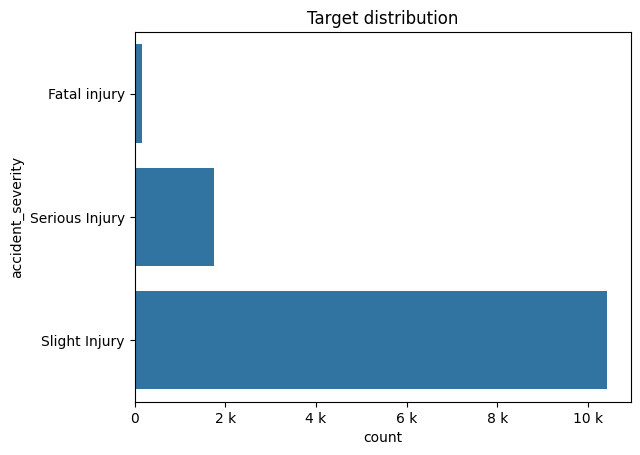

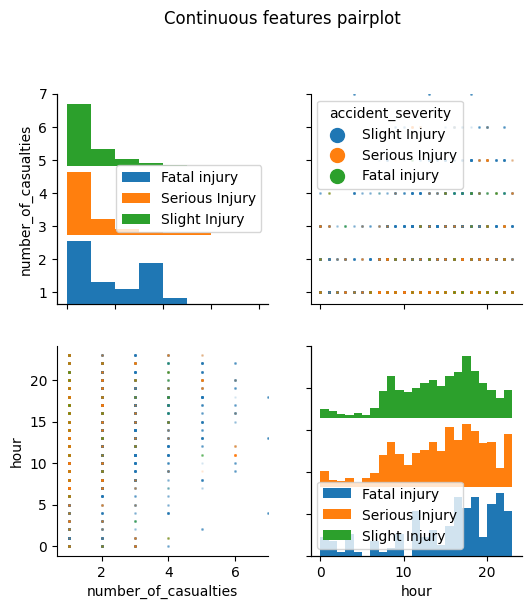

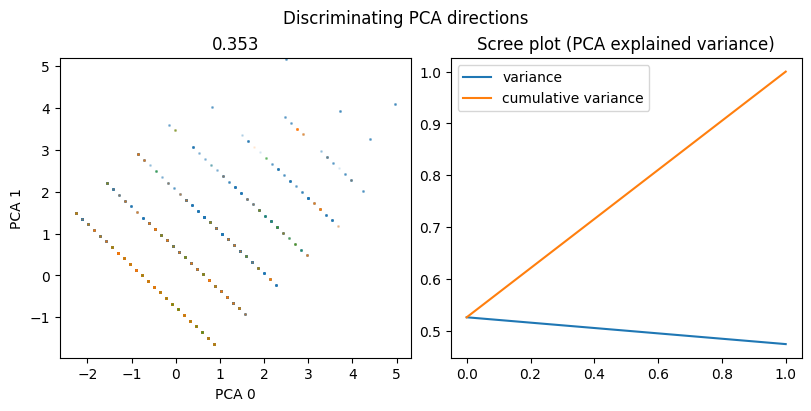

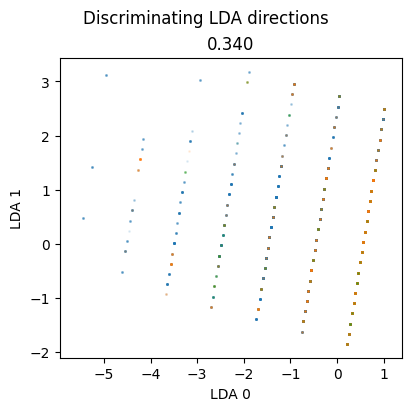

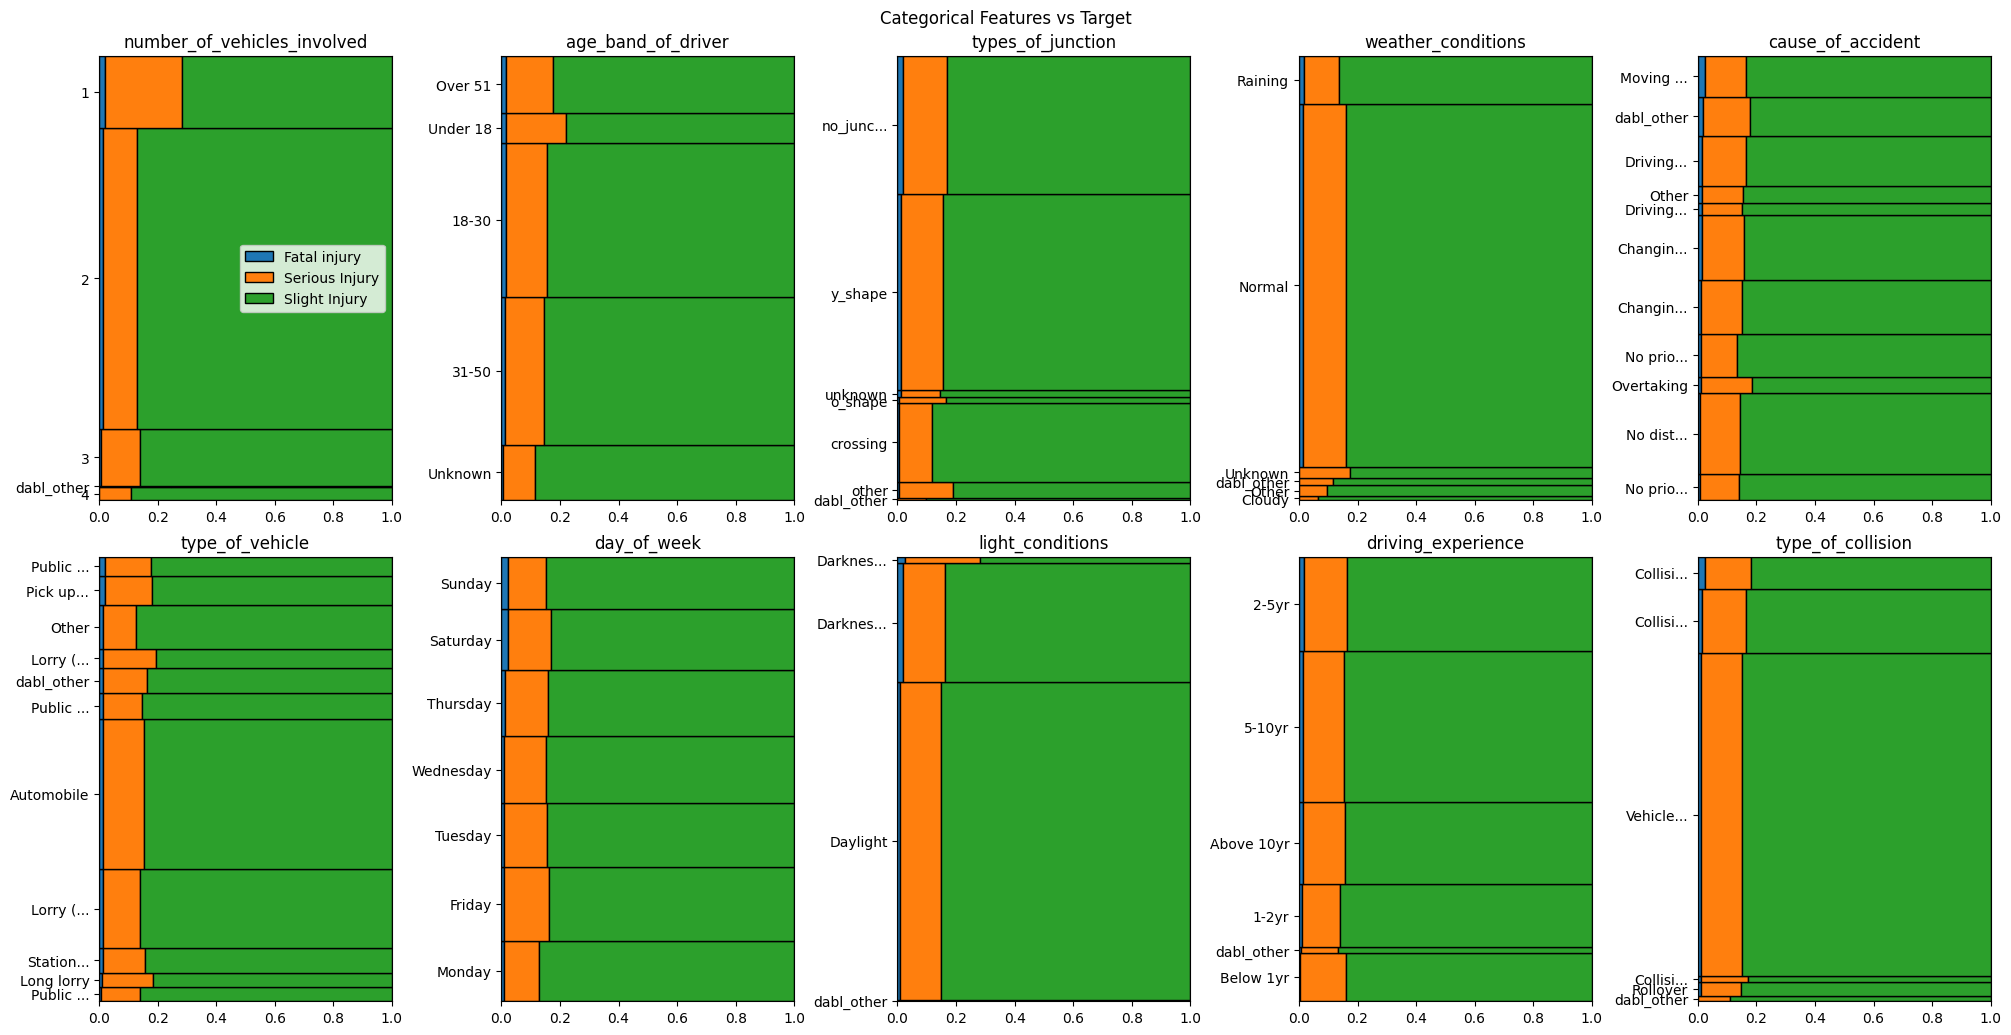

In [36]:
# Visualizing dataset using dabl library
dabl.plot(df_cleaned, target_col="accident_severity")


In [37]:
# From our analysis we can observe that:
# Dataset seems be imbalanced
# More vehicles involved, higher chances of serious injuries
# light_conditions being darkness can cause higher serious injury
# area_accident_occurred, cause_of_accident, day_of_week, type_of_junction, type_of_vehicle, driving_experience can result in higher fatal injuries

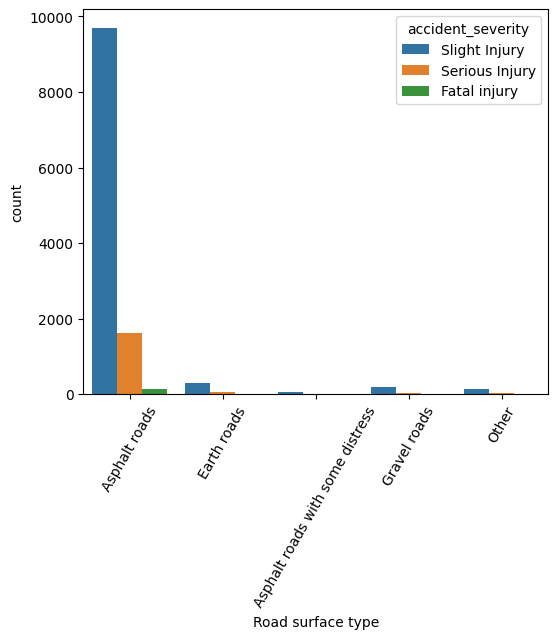

In [38]:
# Plot the bar plot of road_surface_type and accident severity feature
plt.figure(figsize=(6,5))
sns.countplot(x='road_surface_type', hue='accident_severity', data=df_cleaned)
plt.xlabel('Road surface type')
plt.xticks(rotation=60)
plt.show()

# Most accidents happened on "asphalt roads" in the dataset, followed by "earth roads"
# We can conclude that most accidents and fatal injuries occur on asphalt roads, and this is not a significant variable to predict the target class

In [39]:
# Further drop irrelevant columns
df_cleaned.drop(columns=["pedestrian_movement", "road_surface_type", "time"], inplace=True)

# Strip whitespace from all string columns
df_cleaned = df_cleaned.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [40]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   day_of_week                  12316 non-null  object
 1   age_band_of_driver           12316 non-null  object
 2   sex_of_driver                12316 non-null  object
 3   educational_level            12316 non-null  object
 4   vehicle_driver_relation      12316 non-null  object
 5   driving_experience           12316 non-null  object
 6   type_of_vehicle              12316 non-null  object
 7   owner_of_vehicle             12316 non-null  object
 8   area_accident_occured        12316 non-null  object
 9   lanes_or_medians             12316 non-null  object
 10  road_alignment               12316 non-null  object
 11  types_of_junction            12316 non-null  object
 12  road_surface_conditions      12316 non-null  object
 13  light_conditions             12

In [41]:
df_cleaned['accident_severity']

0         Slight Injury
1         Slight Injury
2        Serious Injury
3         Slight Injury
4         Slight Injury
              ...      
12311     Slight Injury
12312     Slight Injury
12313    Serious Injury
12314     Slight Injury
12315     Slight Injury
Name: accident_severity, Length: 12316, dtype: object

In [42]:
# Dropping unnecessary columns JF

df_cleaned.drop(columns=["cause_of_accident", 
                         "type_of_vehicle", 
                         "type_of_collision",
                         "light_conditions",
                         "driving_experience",
                         "sex_of_driver",
                         "owner_of_vehicle",
                          # "area_accident_occured",
                          "day_of_week",
                          "educational_level",
                          "age_band_of_casualty",
                          "age_band_of_driver",
                          "vehicle_driver_relation",
                          "road_surface_conditions",
                          "casualty_severity",
                          "road_alignment",
                          "vehicle_movement",
                          "number_of_casualties",
                          "number_of_vehicles_involved",
                          ], inplace=True)

In [43]:
df_cleaned["lanes_or_medians"] = df_cleaned["lanes_or_medians"].apply(
    lambda x: "two_way" if 'two way' in x.lower() or 'two-way' in x.lower()
    else "one_way" if 'double carriageway' in x.lower()
    else x.strip().replace(" ", "_").lower()
)
df_cleaned["weather_conditions"] = df_cleaned["weather_conditions"].apply(
    lambda x: "rain" if "rain" in x.lower() else "no_rain"
)

In [44]:
categorical_cols = df_cleaned.select_dtypes(include="object").columns  

df_cleaned[categorical_cols].nunique().sort_values(ascending=False)

print(df_cleaned.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   area_accident_occured  12316 non-null  object
 1   lanes_or_medians       12316 non-null  object
 2   types_of_junction      12316 non-null  object
 3   weather_conditions     12316 non-null  object
 4   accident_severity      12316 non-null  object
 5   hour                   12316 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 529.3+ KB
None


In [45]:
# Encode the target variable accident_severity
print(df_cleaned['accident_severity'].unique())
df_cleaned['accident_severity'] = df_cleaned['accident_severity'].map({
    'Slight Injury': 0, 'Serious Injury': 1, 'Fatal injury': 2
})

# One-hot encode categorical features
filtered_cols = [col for col in categorical_cols if col not in ['accident_severity']]
print(filtered_cols)
df_encoded = pd.get_dummies(df_cleaned[filtered_cols]) 
# Ensure all features are numeric (convert bools to ints)
df_encoded = df_encoded.astype(int)

# Define features and target
X = df_encoded
y = df_cleaned['accident_severity']
print(X.shape)
print(y.shape)
print(y.isna().sum())

['Slight Injury' 'Serious Injury' 'Fatal injury']
['area_accident_occured', 'lanes_or_medians', 'types_of_junction', 'weather_conditions']
(12316, 19)
(12316,)
0


In [46]:
# Train using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Imbalance data treatment using SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# New class distribution
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE: ", Counter(y_train_resampled))



Before SMOTE: Counter({0: 8331, 1: 1394, 2: 127})
After SMOTE:  Counter({0: 8331, 1: 8331, 2: 8331})


In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Evaluate Model Performance
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.30      0.44      2084
           1       0.15      0.54      0.23       349
           2       0.01      0.23      0.03        31

    accuracy                           0.33      2464
   macro avg       0.35      0.35      0.23      2464
weighted avg       0.76      0.33      0.41      2464

Confusion Matrix:
 [[ 618 1057  409]
 [  79  187   83]
 [   9   15    7]]


In [48]:
# Train using XGBoost to see if it better supports the class imbalance
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Compute sample weights to help XGBoost handle imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit with sample weights
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 

C:\Users\jerly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [00:22:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.88      0.27      0.42      2084
           1       0.16      0.45      0.24       349
           2       0.02      0.48      0.03        31

    accuracy                           0.30      2464
   macro avg       0.35      0.40      0.23      2464
weighted avg       0.77      0.30      0.39      2464

[[568 825 691]
 [ 68 158 123]
 [  7   9  15]]


In [49]:
# Train using Balanced Random Forest 
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize Balanced Random Forest
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
brf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = brf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.24      0.38      2084
           1       0.15      0.46      0.23       349
           2       0.02      0.45      0.03        31

    accuracy                           0.28      2464
   macro avg       0.35      0.39      0.21      2464
weighted avg       0.76      0.28      0.35      2464

[[506 898 680]
 [ 68 161 120]
 [  6  11  14]]


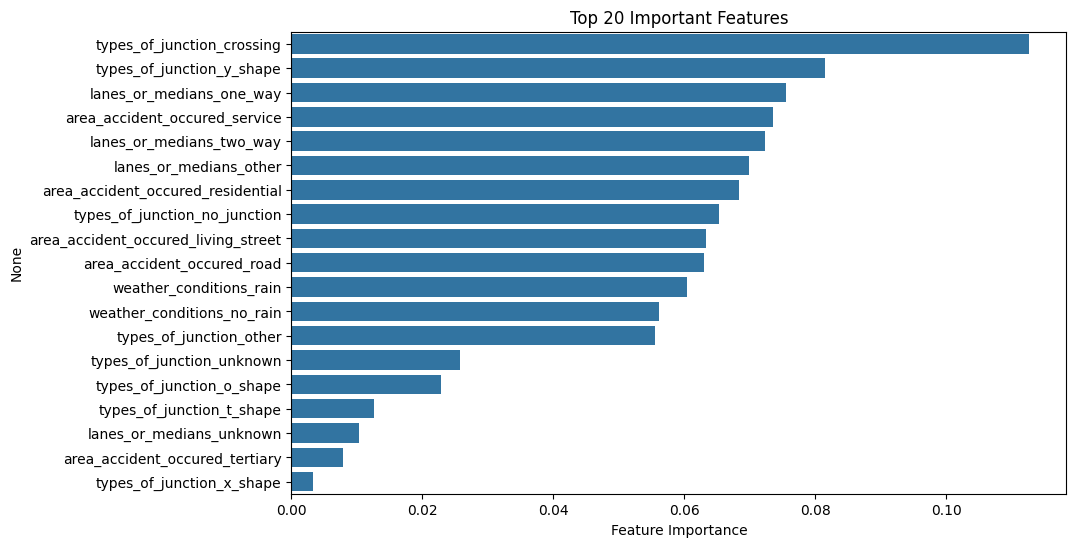

In [50]:
# Feature importance in influencing accident severity

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 20 Important Features")
plt.xlabel("Feature Importance")
plt.show()


In [51]:

# # Create a label encoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Assume you trained on these columns
columns = ["area_accident_occured", "lanes_or_medians", "types_of_junction", "weather_conditions"]
encoders = {}
for col in columns:
    print(df_cleaned[col].unique())  # Check unique values before encoding
# Encode training data
for col in columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])  # Replace original with encoded
    encoders[col] = le  # Save the encoder
print(columns)

['residential' 'service' 'living_street' 'road' 'tertiary']
['two_way' 'other' 'one_way' 'unknown']
['no_junction' 'y_shape' 'crossing' 'o_shape' 'other' 'unknown' 't_shape'
 'x_shape']
['no_rain' 'rain']
['area_accident_occured', 'lanes_or_medians', 'types_of_junction', 'weather_conditions']


In [52]:

encoded_data = {
    "area_accident_occured": 0,  # Example for area_accident_occured
    "lanes_or_medians":0,
    "types_of_junction":0,
    "weather_conditions": 0,
}
# encoded_data = {
#     "area_accident_occured": "service",  # Example for area_accident_occured
#     "lanes_or_medians": "one_way",
#     "types_of_junction": "crossing",
#     "weather_conditions": "rain",
# }

# Encode new input using the fitted encoders
encoded_input = []

for col in columns:
    value = encoded_data[col]
    le = encoders[col]
    
    if value in le.classes_:
        print(f"Encoding value '{value}' for column '{col}'")
        encoded = le.transform([value])[0]
        print(f"Encoded value: {encoded}")
    else:
        print(f"Warning: value '{value}' not seen during training for column '{col}'")
        # You can handle this a few ways:
        # Option 1: skip prediction
        raise ValueError(f"Unknown category '{value}' for column '{col}'")
        
        # Option 2: use a default/fallback (e.g., first class)
        # encoded = le.transform([le.classes_[0]])[0]

    encoded_input.append(encoded)
x_pred = xgb_model.predict([encoded_input])
print("Predicted Accident Severity:", x_pred[0])

ValueError: Unknown category '0' for column 'area_accident_occured'